In this notebook, we are interested to figure out couple of insights in Data Talks Club slack channel.

1. [x] Message frequency over time.
2. [x] Most Used Emojis over time
3. [x] WordCloud (most talked topics within the project course-data-engineering)
4. [x] Network Graph, the people connected to each other (through, message replies, reactions, etc)
5. Is there any correllation between people from similar time zones react with each other more or not.

### Constants and Common Functionalities

This portion of the notebook consist of
- constant variables related to Google Cloud credentials, project, datawarehouse names, data lake, etc
- setup of Python-Google Client and querying

In [1]:
# Set Constant Variables

KEY_PATH      = "../../.google/credentials/terraform-admin.json"

PROJECT_NAME  = "dtc-capstone-344019"
GCS_BUCKET    = "dtc_capstone_344019_data-lake"
DATASET_NAME  = "dtc_capstone_344019_all_data"

## BigQuery Tables :
EXTERNAL_USERS = f"{PROJECT_NAME}.{DATASET_NAME}.ext_users"
EXTERNAL_USERS_IDENTITY = f"{PROJECT_NAME}.{DATASET_NAME}.ext_users_identity"
EXTERNAL_USERS_LOCATION = f"{PROJECT_NAME}.{DATASET_NAME}.ext_users_location"
EXTERNAL_USERS_STATUS   = f"{PROJECT_NAME}.{DATASET_NAME}.ext_users_status"

TABLE_REACTIONS      = f"{PROJECT_NAME}.{DATASET_NAME}.reactions_course-data-engineering"
TABLE_ROOT_MESSAGES  = f"{PROJECT_NAME}.{DATASET_NAME}.root_messages_course-data-engineering"
TABLE_THREAD_REPLIES = f"{PROJECT_NAME}.{DATASET_NAME}.thread_replies_course-data-engineering"

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery.client import Client

In [3]:
credentials = service_account.Credentials.from_service_account_file(
    KEY_PATH, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [4]:
from google.cloud.bigquery.client import Client
import time


def get_query_estimates(client:Client, query:str): 
    job_config = bigquery.QueryJobConfig()
    job_config.dry_run = True
    job_config.use_query_cache = False
    
    query_job = client.query(
        (query),
        job_config=job_config,
    )
    
    print("Estimated: This query will process {} bytes".format(query_job.total_bytes_processed)) 

def run_query(client:Client, query:str):
    
    get_query_estimates(client, query)
    
    query_job = client.query(query)
    
    while(query_job.done() != True):
        time.sleep(1)
    
    print("Actual: This query processed {} bytes".format(query_job.total_bytes_processed))
        
    df = query_job.to_dataframe()
    return df

### Time Series Analysis for Channel Activity

Analysis of number of root-messages and thread-messages will be evaluated over time. 

In [171]:
# Thread Replies from the BigQuery
query_ = """
   SELECT
    FORMAT_TIMESTAMP('%Y-%m-%d', DATETIME(ts)) date,
    COUNT(*) events,
FROM `{table_name}`
GROUP BY
  date
"""
query = query_.format(table_name=TABLE_THREAD_REPLIES)
threads = run_query(client, query) # ts

Estimated: This query will process 0 bytes
Actual: This query processed 0 bytes


In [172]:
# Alternative Approach
# SELECT safe_CAST(ts AS DATETIME) AS ts_datetime,
query_ = """
SELECT
    FORMAT_TIMESTAMP('%Y-%m-%d', DATETIME(ts)) date,
    COUNT(*) events,
FROM `{table_name}`
GROUP BY
  date
"""
query = query_.format(table_name=TABLE_ROOT_MESSAGES)
messages = run_query(client, query) # user, parent_user_id give the relation

Estimated: This query will process 0 bytes
Actual: This query processed 0 bytes


In [173]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

fig = px.histogram(messages, x="date", y="events", histfunc="avg", title="Histogram on Date Axes")
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, dtick="M1", tickformat="%b\n%Y")
fig.update_xaxes(hoverformat="%d-%m-%Y")
fig.update_layout(bargap=0.10)
fig.add_trace(go.Scatter(mode="markers", x=messages["date"], y=messages["events"], name="messages_daily",
                        hovertemplate='%{x} <br> Events: %{y}'))
fig.add_trace(go.Scatter(mode="markers", x=threads["date"], y=threads["events"], name="thread_replies_daily",
                         hovertemplate='%{x} <br> Events: %{y}'))
fig.show()

### Reactions

Evaluation of  the most hot emojis and usage over time.

In [174]:
# Thread Replies from the BigQuery
query_ = """SELECT * FROM `{table_name}` """
query = query_.format(table_name=TABLE_REACTIONS)
reactions = run_query(client, query) # ts

query_ = """SELECT client_msg_id, ts FROM `{table_name}` """
query = query_.format(table_name=TABLE_THREAD_REPLIES)
threads = run_query(client, query) # ts

query_ = """SELECT client_msg_id, ts FROM `{table_name}` """
query = query_.format(table_name=TABLE_ROOT_MESSAGES)
root_messages = run_query(client, query) # ts

Estimated: This query will process 0 bytes
Actual: This query processed 0 bytes
Estimated: This query will process 0 bytes
Actual: This query processed 0 bytes
Estimated: This query will process 0 bytes
Actual: This query processed 0 bytes


#### Most Used Emojis over Course

In [175]:
reactions_counts = reactions.groupby(['name']).size().reset_index(name='count') # size: 5309
reactions_counts = reactions_counts.sort_values(by=['count'], ascending=False)

In [176]:
import plotly.express as px

fig = px.bar(reactions_counts.head(10), x="name", y="count", title="Most Popular 10 Emojis")
fig.show()

#### Reaction Usage over time

In [177]:
root_messages['type'] = 'root'
threads['type'] = 'thread'
root_messages = root_messages.dropna(how='all')
threads = threads.dropna(how='all')
messages = pd.concat([threads, root_messages], axis=0)

In [178]:
reactions = pd.merge(reactions, messages, on='client_msg_id')
reactions1["ts"]=pd.to_datetime(reactions1["ts"])
reactions["year"] =reactions1.ts.dt.year
reactions["month"] =reactions1.ts.dt.month
reactions['period'] = reactions["year"].astype(str) + '-' + reactions["month"].astype(str)

In [179]:
reactions = reactions.groupby(['period', "name"]).size().reset_index(name='count')

In [180]:
import plotly.express as px
fig = px.bar(df, x="period", y="count", color="name", title="Long-Form Input")
fig.show()

### WordCloud: Topics that are discussed most in channels

In that section, the message **text data** will be analysed for the slack channels. \
The analysis is done based on the root_messages, as root messages summary of the main discussion on the thread.\
Therefore, the data from thread_replies table is not included in the analysis.

#### 1. Retrieve the RootMessages from BigQuery

In [214]:
# Required Packages and Manual Installation
%system pip install -U spacy --quiet
%system python -m spacy download en_core_web_sm --quiet

['WARNING: You are using pip version 21.3.1; however, version 22.0.4 is available.',
 "You should consider upgrading via the '/Users/iremertuerk/workspace-personal/Data-Engineering-Zoomcamp-All/dtc-capstone-project/visualization/venv/bin/python -m pip install --upgrade pip' command.",
 '\x1b✔ Download and installation successful\x1b',
 "You can now load the package via spacy.load('en_core_web_sm')"]

In [215]:
# 1. Get the root_messages
query_     = """SELECT text FROM `{table_name}`"""
query      = query_.format(table_name=TABLE_ROOT_MESSAGES)
root_messages = run_query(client, query)

Estimated: This query will process 0 bytes
Actual: This query processed 444979 bytes


#### 2. Tokenize the Text Data

In [216]:
import spacy
from nltk.corpus import stopwords

sp = spacy.load("en_core_web_sm")
spacy_stopwords = sp.Defaults.stop_words

def tokenize_lemmatize_messages(message):
    message = message.lower()
    doc = sp(message)
    lemmas = [token.lemma_ for token in doc]
    lemmas = [lemma for lemma in lemmas if len(lemma) > 2 if not lemma in stopwords.words('english')]
    lemmas = [lemma for lemma in lemmas if not lemma in spacy_stopwords]
    return " ".join(lemmas)

# 2.Tokenize the message text and clean from all stop words
messages_text= root_messages['text'].apply(lambda x: tokenize_lemmatize_messages(x))

#### 3. WordCloud Visualization

In [218]:
# 3.1 Create images directory if not exists
%system mkdir -p ../images

[]

In [220]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud_stopwords = set(STOPWORDS)
# After couple of manual runs in the step 3, the following words also added as stop word in our context
wordcloud_stopwords.update(["use", "run","try", "work", "create","start","help", "find","need",
                            "week", "error", "issue", "question" ,"video", "file","course", "datum","hello"])

def create_wordcloud_figure(text):
    wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                stopwords = wordcloud_stopwords,
                min_font_size = 10).generate(" ".join(text.values))
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("./images/wordcloud.png", format="png")

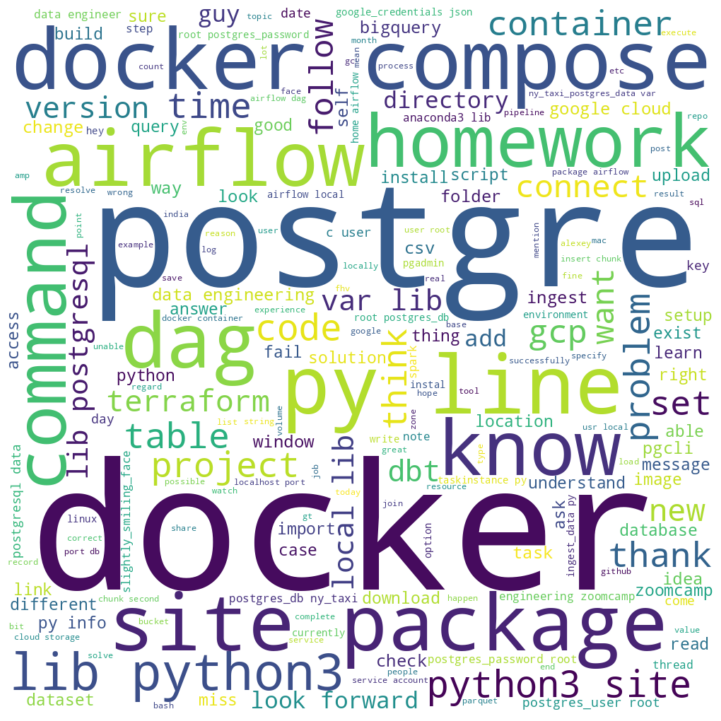

In [221]:
create_wordcloud_figure(messages_text)

### NetworkGraph: See the community structure 

In that section, idea is to build a undirected graph structure to see how connected our data-engineering community is.
Later, we can extend the scope to build a directed graph and/or buid a complete Data Talks Club network graph.

#### 1. Retrieve the Datasets

In [184]:
# 0 Get Users from the BigQuery
# This dataset will be used to find real_names of connected users in later state
query_ = """SELECT id,name, real_name FROM `{table_name}`"""
query  = query_.format(table_name=EXTERNAL_USERS)
users  = run_query(client, query)  # id, name, real_name

Estimated: This query will process 0 bytes
Actual: This query processed 531621 bytes


In [185]:
# 1.1 Thread Replies from the BigQuery
# Thread Replies dataset include parent_user_id and user information
# which give us a connection/communication-line between two persons
query_ = """
    SELECT user, parent_user_id FROM `{table_name}`
"""
query = query_.format(table_name=TABLE_THREAD_REPLIES)
thread_replies = run_query(client, query) # user, parent_user_id give the relation

Estimated: This query will process 0 bytes
Actual: This query processed 176314 bytes


In [186]:
# 1.2. Reactions from the BigQuery
# Similiarly reactions from BigQuery table contains
# msg_owner and msg_reactor information 
# which give us a connection/communication-line between two persons
query_    = """
    SELECT msg_owner, msg_reactor, FROM `{table_name}` 
"""
query     = query_.format(table_name=TABLE_REACTIONS)
reactions = run_query(client, query) # msg-reactor, msg-owner

Estimated: This query will process 0 bytes
Actual: This query processed 131118 bytes


#### 2. Transform datasets in common format

In [187]:
# 2. Transform both data sets into same format
reactions = reactions.rename(columns={'msg_owner':'target', 'msg_reactor':'source'}) #size:5043
thread_replies = thread_replies.rename(columns={'parent_user_id':'target', 'user':'source'}) # size:6786

#### 3. Combine datasets in to single one

In [188]:
import pandas as pd

# 3.1 Create single connections dataframe
connections = pd.concat([reactions,thread_replies], ignore_index=True) # size:1966

# 3.2 Remove self links in the connections
connections = connections.drop(connections[connections.target == connections.source].index) # size: 9320

# 3.3 Create weights for connection-level between two person
most_connected_people = connections.groupby(['target', 'source']).size().reset_index(name='weight') # size: 4988

# Now , we have dataset with target, source, weight columns

#### (optionall) additional Analysis
1. Who responded most in during the course?
2. How people connected with each other over time?

In [189]:
# 3.4: Optional : Answers who is puts most response in channnel.
peoples_response_levels = connections.groupby(['source']).size().reset_index(name='weight') # size: 5309

In [190]:
# 3.5: How people connected with each other over time?
connection_level_distributrion = most_connected_people.groupby(['weight']).size().reset_index(name='#occurance') # 27

import plotly.express as px
fig = px.bar(connection_level_distributrion, x="weight", y="#occurance", title="connection_level_distributrion")
fig.show()
fig.write_html("./images/connection_level_distributrion.html")

FileNotFoundError: [Errno 2] No such file or directory: 'images/connection_level_distributrion.html'

#### .... continue the network analysis

In [191]:
network = most_connected_people # size 4988
network_reduced = network.drop(network[network.weight < 10].index) #size 83

In [192]:
n = network_reduced

#### 4. Merge User Data and Connections Data

In [193]:
# 4. As mentioned in the step 1: Now we are merging network-connections dataset with the users
n = pd.merge(n, users,  how='left', left_on=['target'], right_on = ['id'])
n = n.rename(columns={'id':'target_id', 'name':'target_name', 'real_name': 'target_real_name'}) # size:83
n = pd.merge(n, users,  how='left', left_on=['source'], right_on = ['id'])
n = n.rename(columns={'id':'source_id', 'name':'source_name','real_name': 'source_real_name'}) # size:83
n = n.drop(columns=['target_id', 'source_id'])

#### 5.1. Build Network by using PyVis

In [194]:
import pandas as pd
source_names = list(n['source_name'].unique())
target_names = list(n['target_name'].unique())

unique_names = list(set(source_names + target_names)) # 57 nodes

In [197]:
from pyvis.network import Network


def build_nodes(df, network):
    ids = {}
    source_names = list(df["source_name"].unique())
    target_names = list(df["target_name"].unique())
    unique_nodes = list(set(source_names + target_names))
    for i, node in enumerate(unique_nodes):
        ids[node] = i
        network.add_node(i, label=node)
    return network, unique_nodes, ids


def build_edges(df, network, node_labels, ids):
    # edges = []
    for i, source_node in enumerate(node_labels):
        temp = df.loc[df["source_name"] == source_node]
        temp = temp[["target_name", "weight"]]
        targets_weights = [tuple(x) for x in temp.to_numpy()]
        for tw in targets_weights:
            target_node, weight = ids[tw[0]], tw[1]
            # edge = i, target_node, weight, str(weight)
            network.add_edge(
                i, target_node, value=weight, title=str(weight)
            )  # weight 42
            # edges.append(edge)
    # network.add_edges(edges)
    return network

def build_pyvis_network(df, name):
    network = Network(height="500px", width="900px",notebook=True, directed=False)
    network.barnes_hut(spring_strength=0.006)

    (
        network,
        node_labels,
        label_2_id_mapping,
    ) = build_nodes(df=df, network=network)
    network = build_edges(df, network, node_labels, label_2_id_mapping)

    network.repulsion(node_distance=200, spring_length=200)
    network.show_buttons(filter_=True)
    network.save_graph(f"../images/pyvis_network_{name}.html")
#     network.show('./images/nodes.html')

In [198]:
build_pyvis_network(n, "test")

In [199]:
from IPython.display import IFrame
IFrame(src='../images/pyvis_network_test.html', width=900, height=600)

#### 5.2 Build Network by using NetworkX

In [200]:
%system pip install networkx --quiet
%system pip install plotly --quiet

['WARNING: You are using pip version 21.3.1; however, version 22.0.4 is available.',
 "You should consider upgrading via the '/Users/iremertuerk/workspace-personal/Data-Engineering-Zoomcamp-All/dtc-capstone-project/visualization/venv/bin/python3.9 -m pip install --upgrade pip' command."]

In [201]:
import networkx as nx
G = nx.from_pandas_edgelist(n, source="source_name", target="target_name",edge_attr="weight")

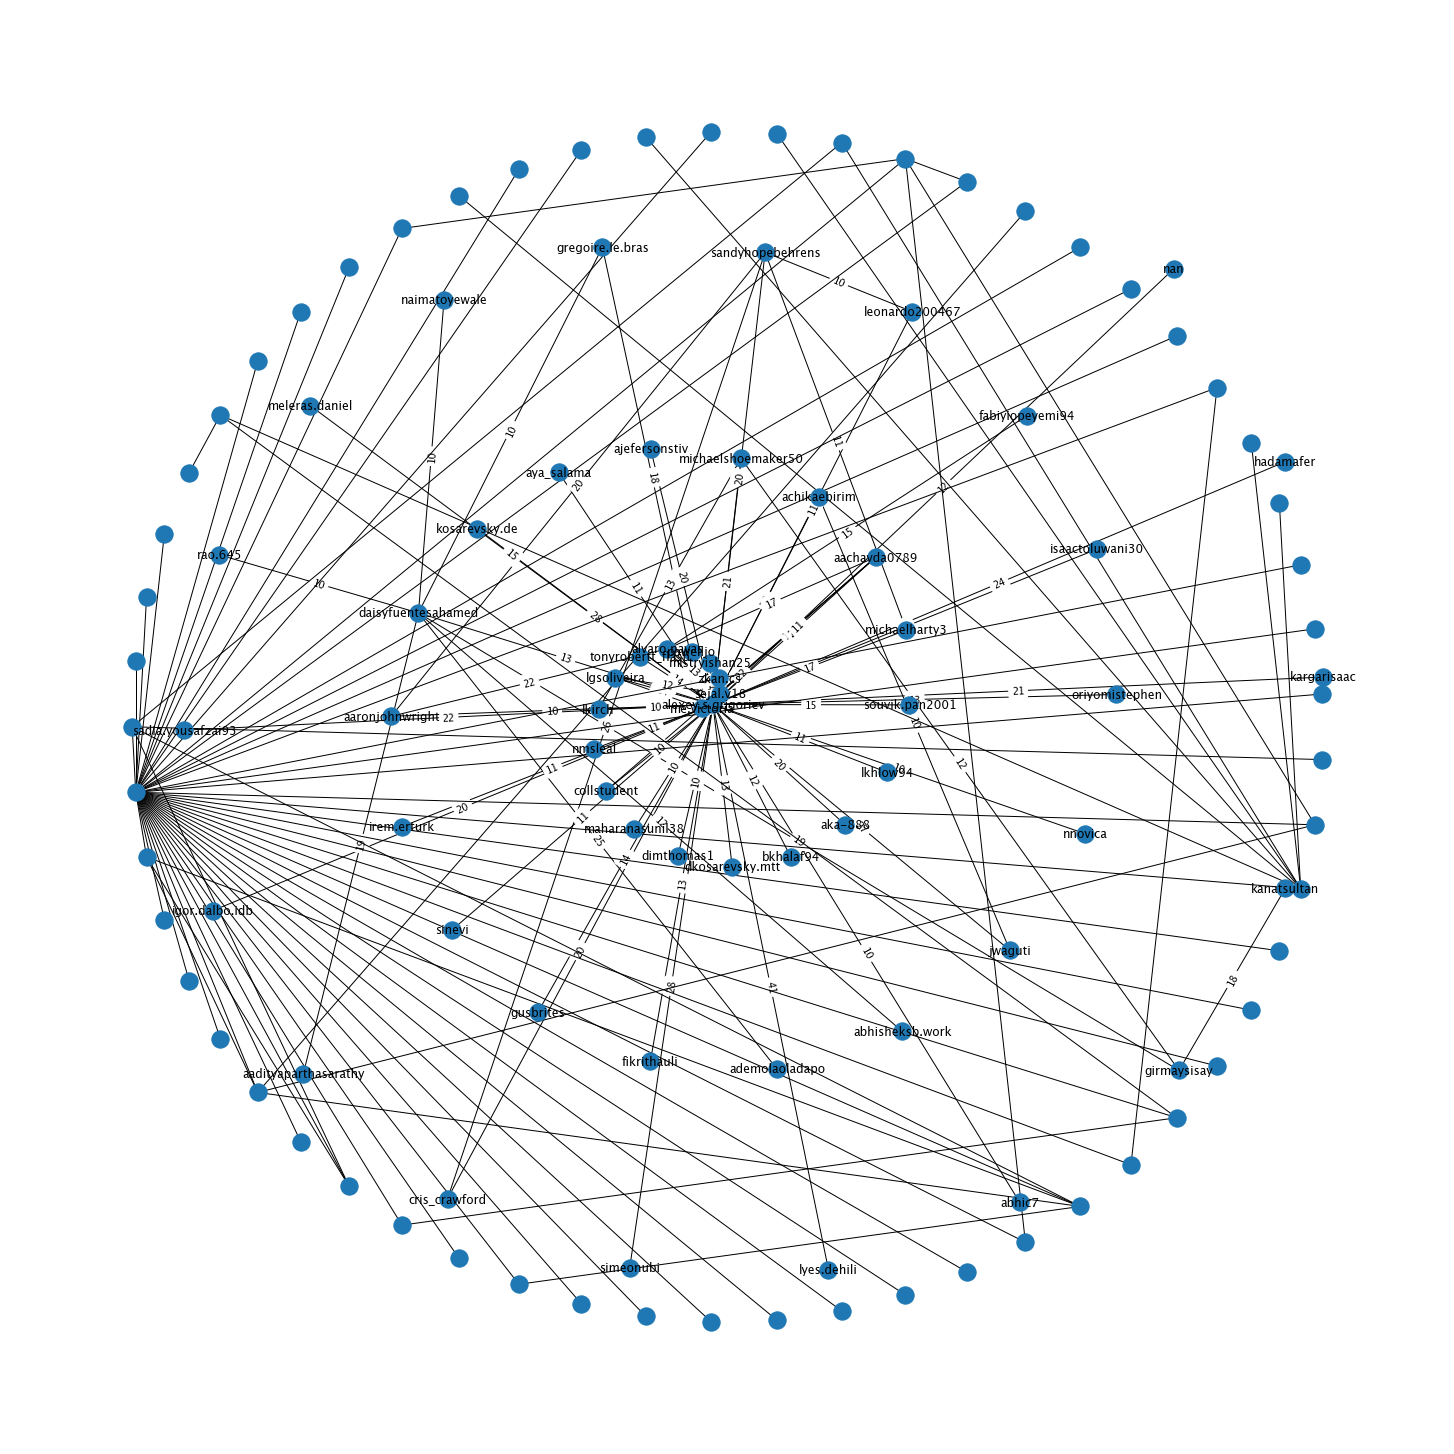

In [205]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 20))
# pos = nx.spring_layout(G, k=100, weight='weight')  # For better example looking
pos = nx.spiral_layout(G) 
nx.draw(G, pos, with_labels=True)
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw_shell(G, with_labels=False)
# nx.draw_networkx_nodes(G, pos)
plt.show()

#### Further Analysis with NetworkX G

In [206]:
import networkx as nx
G = nx.from_pandas_edgelist(n, source="source_name", target="target_name",edge_attr="weight")

In [207]:
def find_leaderboard(G):
    leaderboard = {}
    for node in G.nodes:
        leaderboard[node] = len(G[node])
    s = pd.Series(leaderboard, name='connections')
    print()
    leaders = s.to_frame().sort_values('connections',ascending=False)
    return leaders

In [208]:
leaders = find_leaderboard(G)
leaders.head(10)

,connections
alexey.s.grigoriev,46
daisyfuentesahamed,8
me.victoria,5
sandyhopebehrens,5
alvaro.navas,5
aachavda0789,5
sejal.v18,4
girmaysisay,3
lgsoliveira,3
aaronjohnwright,3


#### 6 NetworkX Visualization with Plotly

In [209]:
import plotly.graph_objects as go

In [210]:
def make_edge(x, y, width):
    width2= width/4
    edge_trace = go.Scatter(
                x=x,
                y=y,
                line=dict(width=width2,color='#888'),
                hoverinfo='none',
                mode='lines')
    
#     edge_trace.text = f'weight: {width2}'
    
    return edge_trace

def create_edge_traces(G):
    edges_traces = []
    xtext=[]
    ytext=[]
    weights=[]
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        xtext.append((x0+x1)/2)
        ytext.append((y0+y1)/2)
        weights.append(edge[2]["weight"])
        edges_trace=make_edge([x0,x1, None],[y0,y1, None],edge[2]["weight"])
        edges_traces.append(edges_trace)
                
#     edge_weights_trace = go.Scatter(x=xtext,y= ytext, mode='text',
#                               marker_size=0.1,
#                               text=0.5,
# #                               hoverinfo='text',
#                               textposition='top center',
# #                               hovertemplate='weight: %{text}<extra></extra>'
#     )
    
    return edges_traces # edge_weights_trace 

def create_node_trace(G):
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=20,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=5))
    
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{adjacencies[0]} # of connections: {len(adjacencies[1])}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    return node_trace 

In [211]:
edge_traces = create_edge_traces(G) # 72 - 1
node_trace  = create_node_trace(G) # 1

In [212]:
traces = edge_traces + [node_trace]  # [edge_weights_trace] #74

In [213]:
fig = go.Figure(data=traces,
             layout=go.Layout(
                title='<br>Network Graph between Data-Engineering Zoomcamp',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()